In [23]:
from Feed_Forward_NN import *
#from train_fn import *
from activation_fns_and_grads import *
from loss_fns_with_regularization import *
from optimizers_with_regularization import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import wandb


In [24]:
!wandb login

wandb: Currently logged in as: anshuman802 (use `wandb login --relogin` to force relogin)


In [25]:
wandb.init(project='MNIST_sweep')

wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [26]:
train_set = torchvision.datasets.MNIST(
    root=''
    ,train=True
    ,download=True
    
)
test_set = torchvision.datasets.MNIST(
    root=''
    ,train=False
    ,download=True
    
)

In [27]:
X_train = np.array(train_set.data)

Y_train = np.array(train_set.targets)

Y_train=Y_train.reshape(-1,1).T

X_train = X_train.reshape(X_train.shape[0],-1).T

X_train, X_val, Y_train, Y_val = train_val_split(X_train, Y_train, val_size=0.1, random_state=42)

In [28]:
# Prior to this define the model
def train(model,
      X_train = X_train,
      Y_train = Y_train,
      X_val = X_val,
      Y_val = Y_val,
      output_activation = "softmax",
      output_loss_fn = "cross_entropy",
      epochs = 15, 
      optimizer_name='adam',
      l2_lambd =0.0005,
      learning_rate = 0.0002,
      lr_schedule = 0.5,
      batch_size = 512,
      print_cost = True, 
      val = True):
    
    train_costs_batches = []
    train_accuracy_batches = []
    
    train_costs=[]
    train_accuracy = []
    val_costs = []
    val_accuracy = []
    
    if optimizer_name=='sgd':
        optimizer = stochastic_gradient_descent(learning_rate=learning_rate , l2_lambd=l2_lambd)
    elif optimizer_name=='momentum':
        optimizer = momentum_gradient_descent(params=model.params,learning_rate= learning_rate , l2_lambd=l2_lambd)
    elif optimizer_name=='rmsprop':
        optimizer = rms_prop(params=model.params,learning_rate= learning_rate , l2_lambd=l2_lambd)
    elif optimizer_name=='adam':
        optimizer = adam(params = model.params, learning_rate= learning_rate , l2_lambd=l2_lambd)
    elif optimizer_name== 'nesterov':
        optimizer = nesterov_gradient_descent(params = model.params, learning_rate= learning_rate , l2_lambd=l2_lambd)
    elif optimizer_name=='nadam':
        optimizer = nadam(params = model.params, learning_rate= learning_rate, beta1=0.9, beta2=0.999 , l2_lambd=l2_lambd)
        
    if batch_size==None:
        batch_size = X_train.shape[1]
        
    for i in range(1,epochs+1):
        if i%10==0:
            optimizer.lr=optimizer.lr * lr_schedule
        '''decay = 0.001
        optimizer.lr=optimizer.lr * 1/(1 + decay * i)'''
        
        mini_batches = create_mini_batches(X_train, Y_train, batch_size)
        no_batches = len(mini_batches)
        
        epoch_loss=0
        epoch_correct=0
        
        
        for j , mini_batch in enumerate(mini_batches,1):
            X_mini, Y_mini = mini_batch
            bs = X_mini.shape[1]
            if bs==0:
                break
            
            # Forward Propagation
            XL = model.forward_prop(X_mini) ## final layer output w/o activation
            Y_pred = act_fn(XL,output_activation)
            
            # Compute cost
            batch_cost = cost_fn(model.params,Y_mini,Y_pred, l2_lambd=l2_lambd, output_activation=output_activation, loss_fn=output_loss_fn)
            batch_correct = np.sum(onehot_to_class(Y_pred)==Y_mini)
            
            epoch_loss += batch_cost*bs
            epoch_correct += batch_correct
            
            # Backward propagation
            ## look forward step
            if optimizer_name=='nesterov' or optimizer_name=='nadam':
                optimizer.update_params_prior_grad(model)
            
            dZ=output_exc_act_grad(Y_mini,Y_pred,output_activation=output_activation,loss_fn=output_loss_fn,classes=model.output_nodes)

            model.backward_prop(dZ)

            # Update parameters.
            if optimizer_name== 'nesterov' or optimizer_name=='nadam':
                optimizer.update_params_after_grad(model)
            else:
                optimizer.update_params(model)

            # Print the cost every 100 training batch
            if j % 100 == 0:
                train_costs_batches.append(batch_cost)
                train_accuracy_batches.append(batch_correct/Y_mini.shape[1])
        
        epoch_loss = epoch_loss / X_train.shape[1]
        epoch_correct = epoch_correct / X_train.shape[1]
        
        train_costs.append(epoch_loss)
        train_accuracy.append(epoch_correct)
        wandb.log({'epoch': i,'train loss': epoch_loss,'train accuracy': epoch_correct})
        if val :
            val_acc,val_loss=accuracy_loss(model,X_val,Y_val,output_activation=output_activation,output_loss_fn=output_loss_fn)
            val_costs.append(val_loss)
            val_accuracy.append(val_acc)
            
            wandb.log({'val loss': val_loss,'val accuracy': val_acc})
            if print_cost:
                print("val cost for epoch ", i , "= ",val_loss)
                print("val accuracy for epoch ", i , "= ",val_acc)
                print("train cost for epoch ", i , "= ",epoch_loss)
                print("train accuracy for epoch ", i , "= ",epoch_correct)
                print("")
            
    # plot the cost per 100 batches
    plt.plot(np.squeeze(train_costs_batches))
    plt.plot(np.squeeze(train_accuracy_batches))
    plt.ylabel('train_costs_batches')
    plt.xlabel('batches (per 100)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    


In [29]:
def layers_config_str(s):
    l=list(map(int, s.split('-')))
    return l

In [30]:
def sp_train():
    config_defaults = {
        'epochs': 15,
        'hidden_layers_config':'512' ,
        'L2_regularization': 0.0005,
        'dropout':0.8,
        'learning_rate': 1e-4,
        'optimizer': 'adam',
        'batch_size': 512,
        'weight_initialization': 'xavier' ,
        'activation_fns': 'relu'
    }
    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    run_name="ep:["+str(config.epochs)+"] hl:["+config.hidden_layers_config+"] lr:["+str(config.learning_rate)+"] op:["+config.optimizer+"] bs:["+str(config.batch_size)+"] ac:["+config.activation_fns+"] L2:["+str(config.L2_regularization)+"] dp:["+str(config.dropout)+"]"
    wandb.run.name=run_name
    #wandb.init(config=config_defaults, name= run_name)
    
    
    
    nn=FeedForward_NN(input_features= 784, 
                  output_nodes=10, 
                  hidden_layers_dims=layers_config_str(config.hidden_layers_config),
                  act_fn=config.activation_fns,
                  dropout = config.dropout,
                  initialization=config.weight_initialization)
    
    train(model=nn,
          X_train = X_train,
          Y_train = Y_train,
          X_val = X_val,
          Y_val = Y_val,
          output_activation = "softmax",
          output_loss_fn = "cross_entropy",
          epochs = config.epochs, 
          optimizer_name= config.optimizer,
          l2_lambd = config.L2_regularization,
          learning_rate = config.learning_rate,
          lr_schedule = 1,
          batch_size = config.batch_size,
          print_cost = True, 
          val = True)

In [31]:
sweep_config = {
    'method': 'grid', 
    'metric': {
      'name': 'val accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values':[15]
        },
        'hidden_layers_config': {
            'values': ['64-32', 
                       '512'
                       ]
        },
        'L2_regularization': {
            'values':[0.0005] 
        },
        'dropout':{
            'values':[0.8]
        },
        'learning_rate':{
            'values': [2e-4,1e-4]
        },
        'optimizer': {
            'values':['adam']
        },
        'batch_size': {
            'values':[512]
        },
        'weight_initialization': {
            'values':['xavier'] 
        },
        'activation_fns': {
            'values':['relu']
        }
    }
}

In [32]:
sweep_id = wandb.sweep(sweep_config, project="Sweep_final")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 377wrv08
Sweep URL: https://wandb.ai/anshuman802/Sweep_final/sweeps/377wrv08


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: lgqn9dez with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 512
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 64-32
wandb: 	learning_rate: 0.0002
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


val cost for epoch  1 =  0.6075528956197486
val accuracy for epoch  1 =  0.818
train cost for epoch  1 =  1.254910715706848
train accuracy for epoch  1 =  0.5560555555555555

val cost for epoch  2 =  0.4198978756360271
val accuracy for epoch  2 =  0.8785
train cost for epoch  2 =  0.4972064336876352
train accuracy for epoch  2 =  0.8574444444444445

val cost for epoch  3 =  0.3407954638123311
val accuracy for epoch  3 =  0.8995
train cost for epoch  3 =  0.3840587814116304
train accuracy for epoch  3 =  0.8936481481481482

val cost for epoch  4 =  0.29646084092281194
val accuracy for epoch  4 =  0.915
train cost for epoch  4 =  0.3241787540250492
train accuracy for epoch  4 =  0.9115

val cost for epoch  5 =  0.26855415413676403
val accuracy for epoch  5 =  0.9198333333333333
train cost for epoch  5 =  0.2861238471471489
train accuracy for epoch  5 =  0.9230555555555555

val cost for epoch  6 =  0.24081213094581677
val accuracy for epoch  6 =  0.9305
train cost for epoch  6 =  0.254920

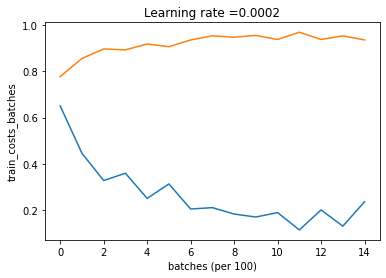

epoch,15
train loss,0.15353
train accuracy,0.95993
_runtime,76
_timestamp,1615620499
_step,29
val loss,0.17122
val accuracy,0.952


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
train accuracy,▁▆▇▇▇██████████
_runtime,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
val accuracy,▁▄▅▆▆▇▇▇▇██████


wandb: Agent Starting Run: v37638k9 with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 512
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 64-32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


val cost for epoch  1 =  0.8485459661133167
val accuracy for epoch  1 =  0.7256666666666667
train cost for epoch  1 =  1.5575984322444518
train accuracy for epoch  1 =  0.49924074074074076

val cost for epoch  2 =  0.5620295886190994
val accuracy for epoch  2 =  0.833
train cost for epoch  2 =  0.6916554408475317
train accuracy for epoch  2 =  0.7894814814814815

val cost for epoch  3 =  0.4491722677135669
val accuracy for epoch  3 =  0.87
train cost for epoch  3 =  0.5025584743903371
train accuracy for epoch  3 =  0.8566296296296296

val cost for epoch  4 =  0.39324195105774007
val accuracy for epoch  4 =  0.884
train cost for epoch  4 =  0.4194076596472406
train accuracy for epoch  4 =  0.8828888888888888

val cost for epoch  5 =  0.35186698836824065
val accuracy for epoch  5 =  0.8991666666666667
train cost for epoch  5 =  0.3758423000908304
train accuracy for epoch  5 =  0.8962222222222223

val cost for epoch  6 =  0.327401639439632
val accuracy for epoch  6 =  0.9038333333333334
t

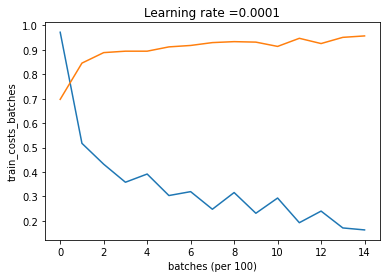

epoch,15
train loss,0.20597
train accuracy,0.9457
_runtime,72
_timestamp,1615620582
_step,29
val loss,0.2129
val accuracy,0.94033


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
train accuracy,▁▆▇▇▇▇█████████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
val accuracy,▁▅▆▆▇▇▇▇▇██████


wandb: Agent Starting Run: 2wwlxoxi with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 512
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0002
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


val cost for epoch  1 =  0.17660849680508028
val accuracy for epoch  1 =  0.945
train cost for epoch  1 =  0.41947270010857957
train accuracy for epoch  1 =  0.8895925925925926

val cost for epoch  2 =  0.11225661961798922
val accuracy for epoch  2 =  0.9675
train cost for epoch  2 =  0.13750991022158657
train accuracy for epoch  2 =  0.9638518518518518

val cost for epoch  3 =  0.09723494680416474
val accuracy for epoch  3 =  0.971
train cost for epoch  3 =  0.09041369516429089
train accuracy for epoch  3 =  0.9771296296296297

val cost for epoch  4 =  0.08498195315219446
val accuracy for epoch  4 =  0.9748333333333333
train cost for epoch  4 =  0.06986751609636525
train accuracy for epoch  4 =  0.9833888888888889

val cost for epoch  5 =  0.08103364832694732
val accuracy for epoch  5 =  0.9748333333333333
train cost for epoch  5 =  0.05464929900945963
train accuracy for epoch  5 =  0.9874444444444445

val cost for epoch  6 =  0.06720177709205497
val accuracy for epoch  6 =  0.9798333

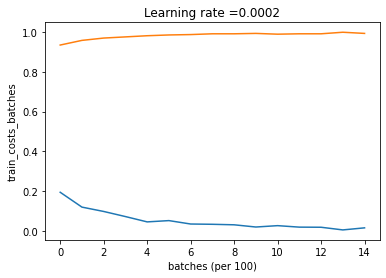

epoch,15
train loss,0.01172
train accuracy,1.00076
_runtime,236
_timestamp,1615620828
_step,29
val loss,0.07558
val accuracy,0.98083


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
train accuracy,▁▆▇▇▇▇█████████
_runtime,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▄▃▂▂▁▂▂▁▁▁▁▂▂▂
val accuracy,▁▅▆▇▇██▇███████


wandb: Agent Starting Run: p94f7z48 with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 512
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


val cost for epoch  1 =  0.23529170828630588
val accuracy for epoch  1 =  0.934
train cost for epoch  1 =  0.5304424484266512
train accuracy for epoch  1 =  0.8682222222222222

val cost for epoch  2 =  0.16833101553432173
val accuracy for epoch  2 =  0.9515
train cost for epoch  2 =  0.1969954096723055
train accuracy for epoch  2 =  0.9477592592592593

val cost for epoch  3 =  0.11750989227804674
val accuracy for epoch  3 =  0.9675
train cost for epoch  3 =  0.13174509068752485
train accuracy for epoch  3 =  0.9664074074074074

val cost for epoch  4 =  0.10386717408071582
val accuracy for epoch  4 =  0.9701666666666666
train cost for epoch  4 =  0.09925941141047252
train accuracy for epoch  4 =  0.9750740740740741

val cost for epoch  5 =  0.09414691546564033
val accuracy for epoch  5 =  0.9723333333333334
train cost for epoch  5 =  0.08043469611347215
train accuracy for epoch  5 =  0.9813518518518518

val cost for epoch  6 =  0.08213828664307828
val accuracy for epoch  6 =  0.9765
tra

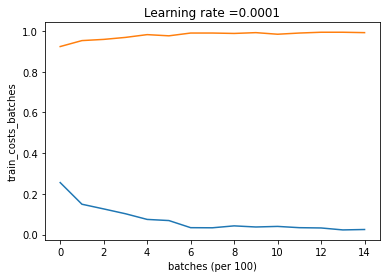

epoch,15
train loss,0.01693
train accuracy,0.99983
_runtime,231
_timestamp,1615621068
_step,29
val loss,0.07691
val accuracy,0.97767


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁
train accuracy,▁▅▆▇▇▇▇████████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▂
val accuracy,▁▄▆▆▇▇▇▇██████▇


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [33]:
wandb.agent(sweep_id, sp_train)